# Tutorial 8 - B - Dark field bacterial motion
Welcome to the Bacterial motion tutorial !
In this notebook, we'll infer the roto-translational dynamics of
anisotropic particles from the structure function obtained with DDM.



This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the basic tutorial 1 to 6.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `APPLICATION_DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686). You might need to unzip the video file.

Your main directory tree should resemble the following:
```
.
├── APPLICATION_DATASET
│   └── ...
├── Tutorial_8-Bacterial_motion
│   └── Tutorial8a.ipynb
│   └── ...
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of uspension of DH5α strain, a non-flagellated bacterium, in PBS solution. To avoid sedimentation, Percoll® was added to the suspension to match the solvent density to that of the bacteria. The concentration of bacteria was kept very low: ∼ 105 bacteria/ml, corresponding to a volume fraction $\phi \simeq 2 \times 10^{−7}$. The sample was finally confined into a 0.3 × 1 × 20 mm rectangular glass capillary, which
was then carefully sealed on both ends onto a microscope glass slide with vaseline petroleum jelly to prevent evaporation. The viscosity of the solvent at the experimental temperature, measured with a capillary viscometer, was found to be $\eta = (1.87 \pm 0.02) \cdot 10^{-3}$ Pa s.

Dark-field images were acquired using a Nikon Eclipse Ti-E microscope equipped with a Orca Flash 4.0 v2 (Hamamatsu) fast digital CMOS camera at 20 fps, using a $20 \times$ NA 0.15  yielding an effective pixel size $\delta _\mathrm{px} = 0.591 ~\mathrm{\mu m}$. The sample was illuminated with a condenser stage (NAc = 0.4) coupled with a PH3 phase-contrast ring mask. The sample temperature was maintained at room temperature $T = 24~\mathrm{^\circ C}$ .


### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:

import os
import lmfit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

mpl.rcParams['lines.markeredgewidth'] = 0.7

def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.plasma,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

import fastddm as fddm
from fastddm.fit import fit

## Compute the image structure function and the azimuthal averages

In [2]:
main_dir = '../APPLICATION_DATASET/DARK_FIELD/'

# list of file names
file_names = [
    'Acq_5_',
]

N_imgs = [
    10085,
]

# pixel size
pixel_size = [
    1.29,    # micrometer/pixel
]

# frame rate
frame_rate = [
    20.0,    # frames/s
]

# list of labels
labels = [
    'DF',
]

In [3]:
# compute image structure function and azimuthal average
dqt = []
aa = []

for n, f in enumerate(file_names):
    print(f"Analyzing movie #{n+1} of {len(file_names)}...")
    # read image sequence
    img_seq = fddm.read_images([os.path.join(main_dir, f"{f}{i+1:05}.tif") for i in range(N_imgs[n])])
    
    # compute minimum intensity
    I0 = np.min(img_seq, axis=0)
    
    # remove background
    img_seq -= I0
    
    # compute image structure function
    dqt.append(fddm.ddm(img_seq, range(1,len(img_seq)), core='cuda'))
    # set pixel size and time delay
    dqt[n].pixel_size = pixel_size[n]
    dqt[n].set_frame_rate(frame_rate[n])
    
    # compute azimuthal average
    # we go to high q, it's easier to just create a list of bin edges using delta_q as the unit
    bin_size = dqt[n].ky[dqt[n].shape[1]//2+1]
    bins = int(np.sqrt(dqt[n].ky[-1]**2 + dqt[n].kx[-2]**2)/bin_size)
    bin_edges = [bin_size for i in range(bins)]
    # mask out the central cross
    ccm = fddm.mask.central_cross_mask(dqt[n].shape[1:])
    bin_range = (0, bin_size * bins)
    # compute
    aa.append(fddm.azimuthal_average(dqt[n], bins=bins, range=bin_range, mask=ccm))

Analyzing movie #1 of 1...


## Estimate the noise factor



In [4]:

# polyfit method
Bq = []
Aq = []
for n, a in enumerate(aa):
    a_tmp = a.resample(a.tau)
    a_tmp._err = np.ones_like(a_tmp._err)
    a_tmp._err[:, :-2] = np.sqrt(a_tmp.tau)
    best, _ = fddm.noise_est.estimate_camera_noise(a_tmp,
                                                      mode="polyfit",
                                                      num_points=3)
    Bq.append(best)
    Aq.append(2.0 * a.var - best)

## Resample azimuthal averages and fit with simple exponential model

In [5]:
aa_res = []

for a in aa:
    new_tau = fddm.lags.logspace_int(len(a.tau) // 8, num=50) * a.tau[0]
    aa_res.append(a.resample(new_tau))

In [6]:
from fastddm.fit import fit_multik
from fastddm.fit_models import double_exponential_model as model

model.set_param_hint("beta1", value=1.0, vary=False)
model.set_param_hint("beta2", value=1.0, vary=False)


# choose reference k vector
k_ref = 60
print(aa_res[0].k[k_ref])

0.5678141996339836


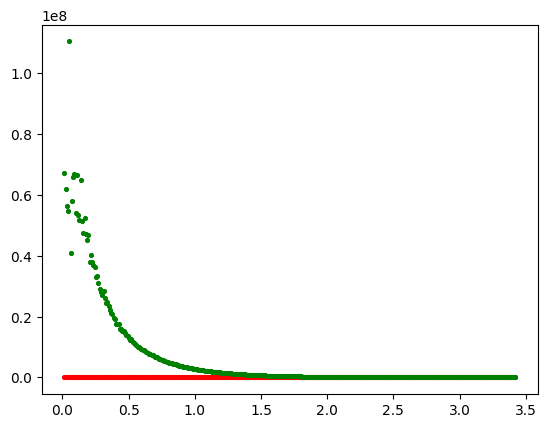

In [7]:
fig1 = plt.figure()
fig1.tight_layout()
ax1 = fig1.add_subplot(1, 1, 1)

ax1.plot(aa_res[0].k, Bq[0], 'r.')
ax1.plot(aa_res[0].k, aa_res[0].power_spec-Bq[0], 'g.')

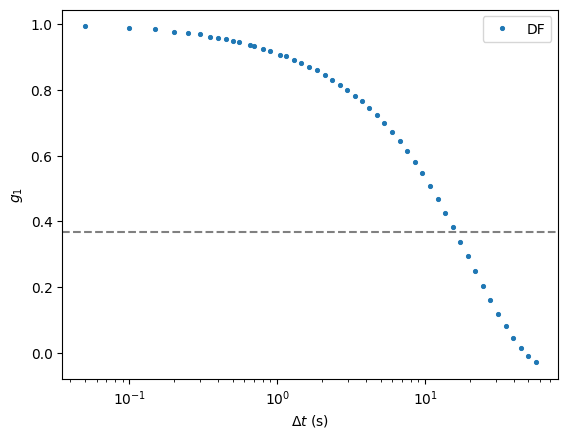

In [8]:
# show the curves at the reference k vector
fig1 = plt.figure()
fig1.tight_layout()
ax1 = fig1.add_subplot(1, 1, 1)

for n, a in enumerate(aa_res):
    ax1.plot(a.tau, 1 - (a.data[k_ref] - Bq[n][k_ref])/Aq[n][k_ref], '.', label=labels[n])

ax1.axhline(y=np.exp(-1), color='gray', linestyle='--')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\Delta t$ (s)')
ax1.set_ylabel(r'$g_1$')
ax1.legend();

In [9]:
fit_res = []
model_res = []

for n, a in enumerate(aa_res):
    # find reference tau
    y = 1 - (a.data[k_ref] - Bq[n][k_ref])/Aq[n][k_ref]
    tau = a.tau[np.argmin(np.abs(y-np.exp(-1)))]
    
    # set model parameters hints
    model.set_param_hint("B", value=Bq[n][k_ref], vary=True)
    model.set_param_hint("A", value=Aq[n][k_ref], vary=True)
    model.set_param_hint("Gamma1", min=0.5, max=np.inf, value=0.9)
    model.set_param_hint("Gamma2", value=0.156*a.k[k_ref]**2)
    #model.set_param_hint("Gamma2", value=0.16, min=0.1, max=0.3)
    model.set_param_hint("alpha", value=0.1)
    
    # fix parameters
    #fixed_params = {'B': B_est["polyfit"][n], 'A': 2.0 * a.power_spec - B_est["polyfit"][n]}#, "q": a.k}
    fixed_params = None
    
    # fit
    res, mres = fit_multik(a, model, k_ref,
                           use_err=False, weights=1/np.sqrt(a.tau),
                           return_model_results=True,
                           fixed_params=fixed_params)
    fit_res.append(res)
    model_res.append(mres)

In [10]:
import seaborn as sns

## Relaxation rate fit results

[('DF', 0.14857802459639102, 0.0007049488489745986)]
[('DF', 0.1645938850919828, 0.0015845034385165205)]


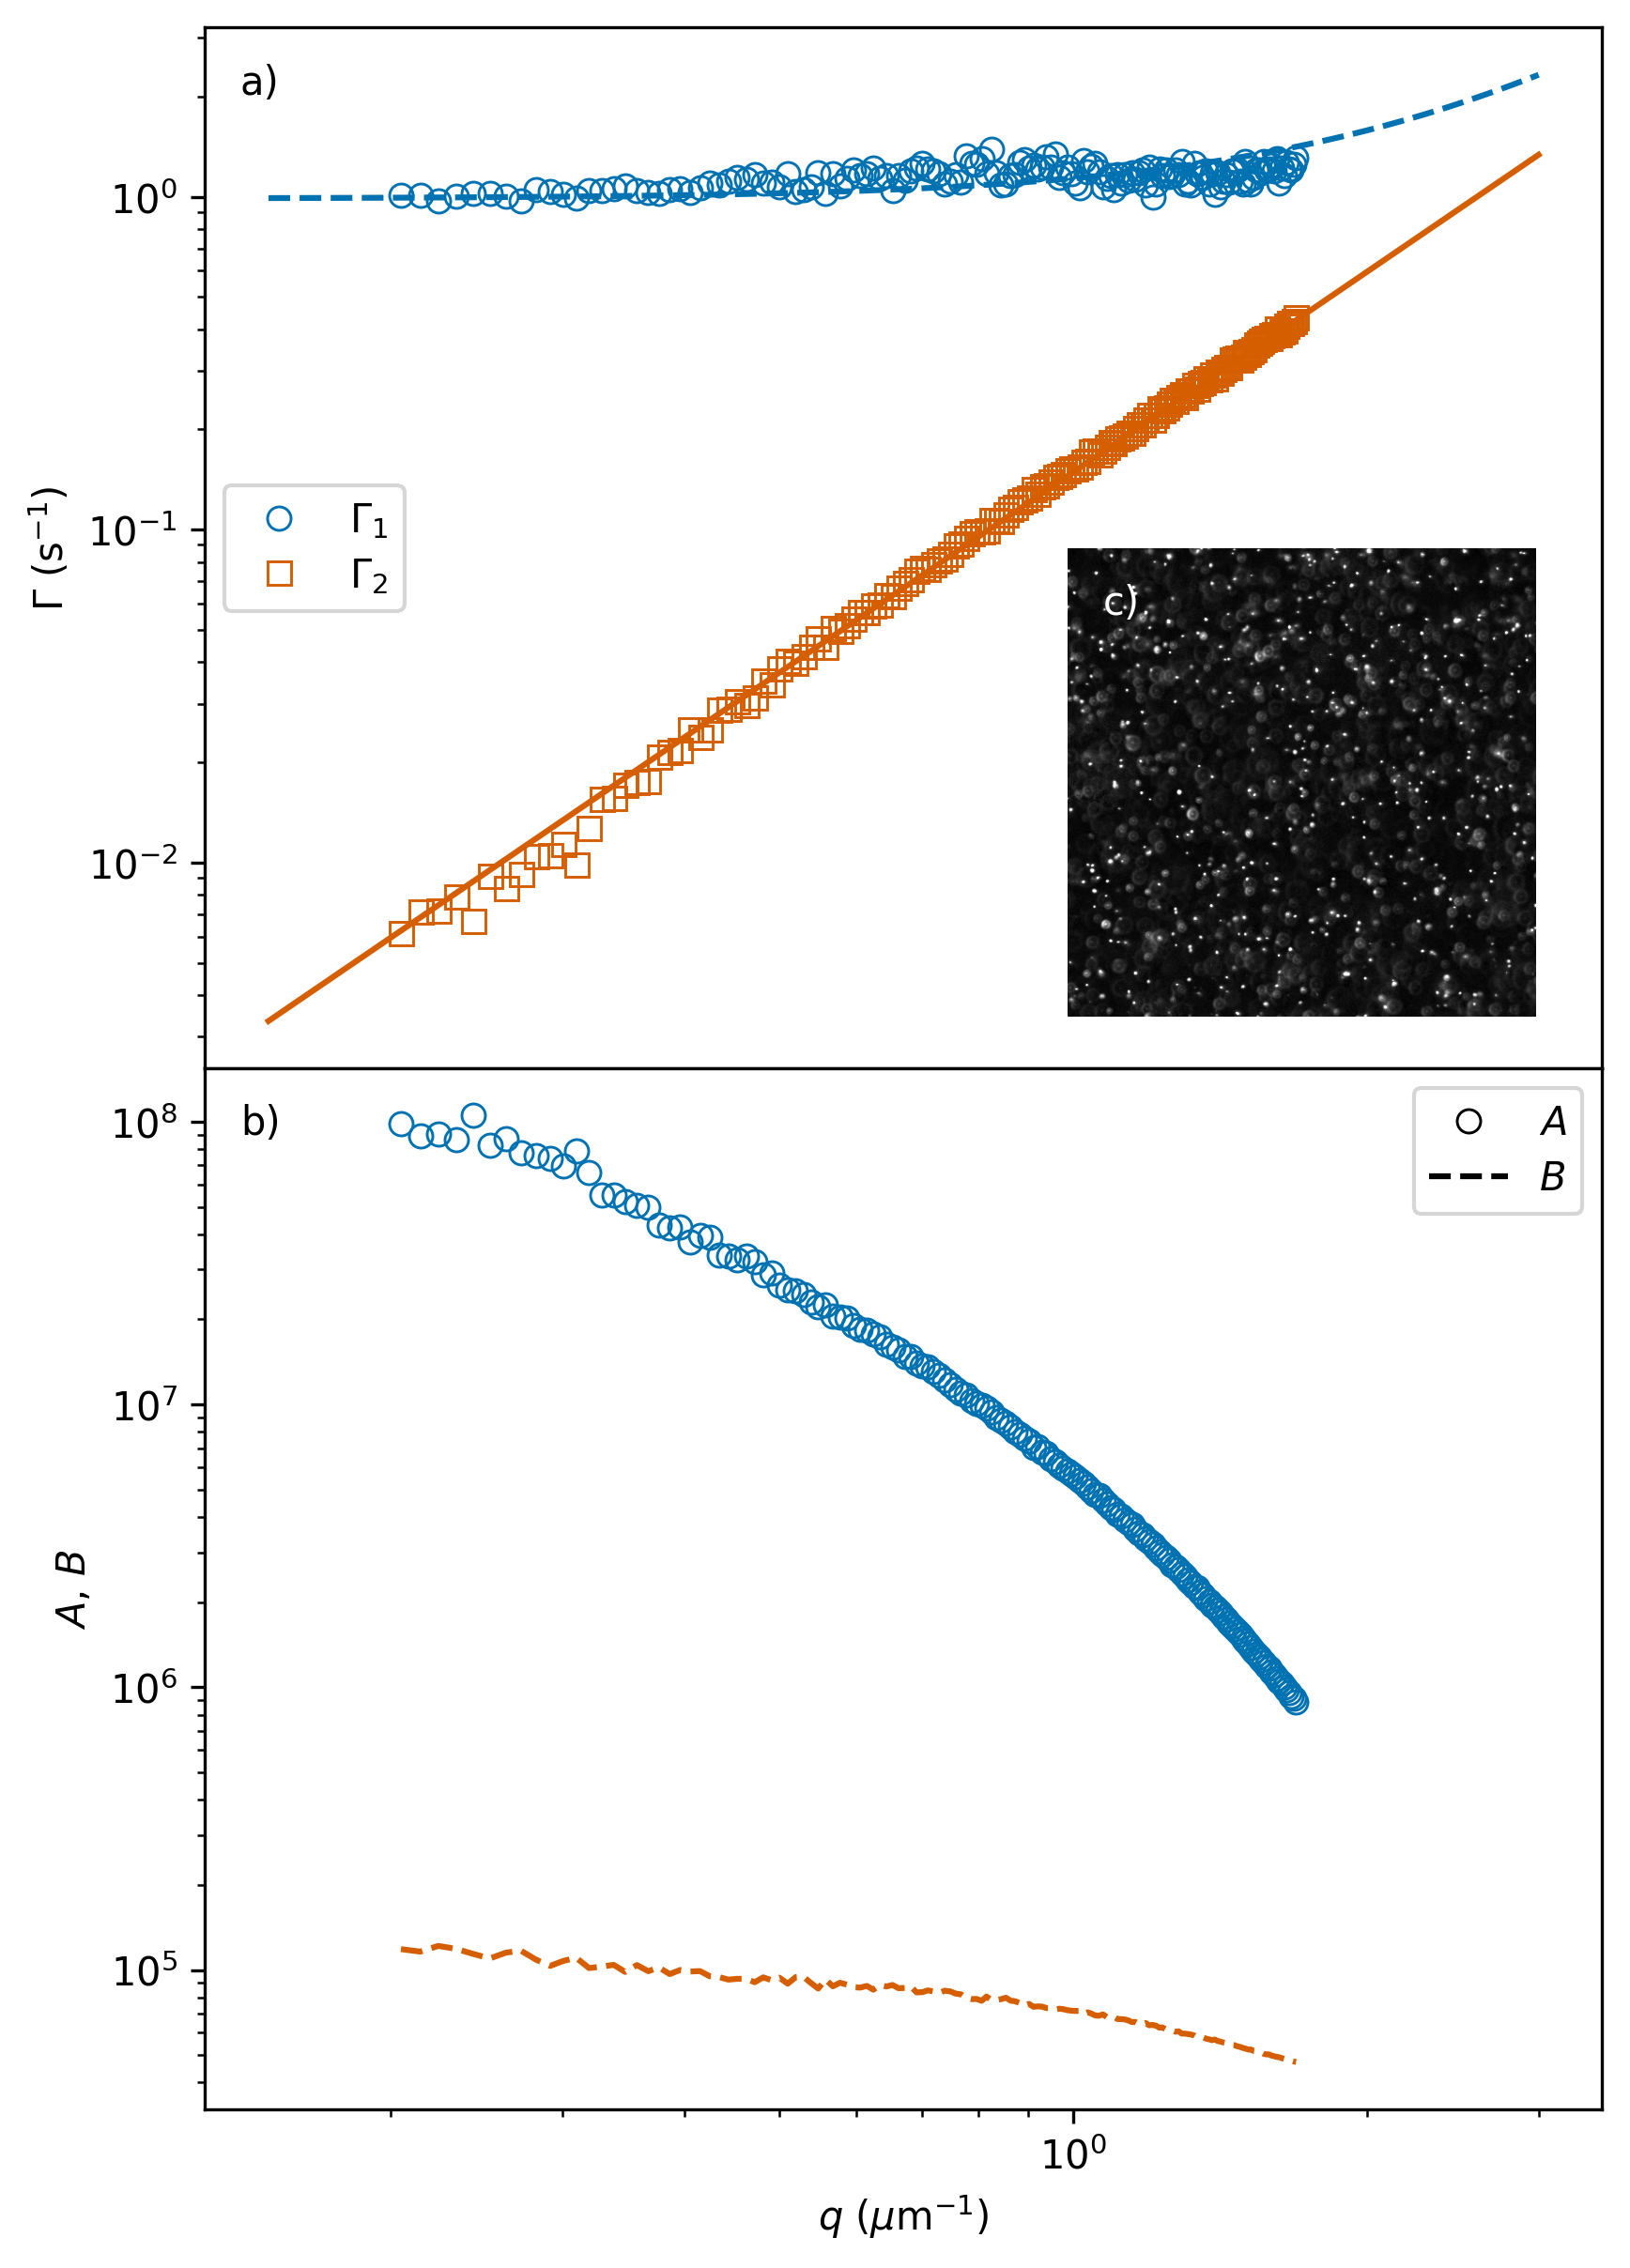

In [11]:
show_transparency = False

fig3 = plt.figure(dpi=300)
fig3.tight_layout()
fig3.set_figheight(2.0 * fig3.get_figheight())
gs3 = fig3.add_gridspec(2, hspace=0)
axs3 = gs3.subplots(sharex=True)
custom_colors = [
        "#0072B2",  # Blue
        "#D55E00",  # Vermillion
        "#009E73",  # Bluish Green
        "#E3C00D",  # Yellow
        "#CC79A7",  # Reddish Purple
        "#56B4E9",  # Sky Blue
        "#E69F00",  # Orange
        "#000000"   # Black
        ]

    # Register as a Seaborn palette
colors_ = sns.set_palette(sns.color_palette(custom_colors))
colors = sns.color_palette(colors_, n_colors= 2,)
# define k ranges
k_min = [0.2]
k_max = [1.7]
k_mask = []
for n, fr in enumerate(fit_res):
    k_mask.append((fr["k"] >= k_min[n]) & (fr["k"] <= k_max[n]))
    
# fit Gamma2 in k range
# define model for Gamma2
def log_Gamma2(x, Dt):
    return np.log(Dt * x**2)

# fit Gamma1 in k range
# define model for Gamma1
def log_Gamma1(x, Dt, Dr):
    return 6 * Dr + Dt * x**2


# fit first Gamma2
model_Gamma2 = lmfit.Model(log_Gamma2, nan_policy="omit")
model_Gamma2.set_param_hint("Dt", min=0.0, value=1.0)

Dt = []
Dt_err = []
for n, fr in enumerate(fit_res):
    Gamma2_fit_res = fit(model_Gamma2,
                         xdata=fr["k"][k_mask[n]],
                         ydata=np.log(fr["Gamma2"][k_mask[n]]))
    Dt.append(Gamma2_fit_res.params["Dt"].value)
    Dt_err.append(Gamma2_fit_res.params["Dt"].stderr)

# fit then Gamma1 fixing Dt
model_Gamma1 = lmfit.Model(log_Gamma1, nan_policy="omit")
model_Gamma1.set_param_hint("Dt", min=0.0)
model_Gamma1.set_param_hint("Dr", min=0.0, value=1.0)

Dr = []
Dr_err = []
for n, fr in enumerate(fit_res):
    model_Gamma1.set_param_hint("Dt", value=Dt[n], vary=False)
    Gamma1_fit_res = fit(model_Gamma1,
                         xdata=fr["k"][k_mask[n]],
                         ydata=fr["Gamma1"][k_mask[n]])#np.log(fr["Gamma1"][k_mask[n]]))
    Dr.append(Gamma1_fit_res.params["Dr"].value)
    Dr_err.append(Gamma1_fit_res.params["Dr"].stderr)


# plot Gamma data
for n, fr in enumerate(fit_res):
    axs3[0].plot(fr["k"][k_mask[n]], fr["Gamma1"][k_mask[n]], f"o",color=colors[n], markerfacecolor="none", label=r"$\Gamma_1$")
    axs3[0].plot(fr["k"][k_mask[n]], fr["Gamma2"][k_mask[n]], f"s", color=colors[n+1], markerfacecolor="none", label=r"$\Gamma_2$")
    if show_transparency:
        axs3[0].plot(fr["k"][~k_mask[n]], fr["Gamma1"][~k_mask[n]], f"o", color=colors[n], markerfacecolor="none", alpha=0.2)
        axs3[0].plot(fr["k"][~k_mask[n]], fr["Gamma2"][~k_mask[n]], f"s", color=colors[n+1], markerfacecolor="none", alpha=0.2)
    # plot fit
    k_plot = np.logspace(np.log10(0.15), np.log10(3), num=100)
    axs3[0].plot(k_plot, 6 * Dr[n] + Dt[n] * k_plot**2, f"--", color=colors[n])
    axs3[0].plot(k_plot, Dt[n] * k_plot**2, f"-", color=colors[n+1])

# plot A and B
for n, fr in enumerate(fit_res):
    axs3[1].plot(fr["k"][k_mask[n]], fr["A"][k_mask[n]], f"o", color=colors[n], markerfacecolor="none", label=labels[n])
    axs3[1].plot(fr["k"][k_mask[n]], fr["B"][k_mask[n]], f"--", color=colors[n+1], markerfacecolor="none")
    if show_transparency:
        axs3[1].plot(fr["k"][~k_mask[n]], fr["A"][~k_mask[n]], f"o", color=colors[n], markerfacecolor="none", alpha=0.2)
        axs3[1].plot(fr["k"][~k_mask[n]], fr["B"][~k_mask[n]], f"s", color=colors[n+1], markerfacecolor="none", alpha=0.2)
custom_lines = [Line2D([0], [0], marker="o", linestyle="none", color="black", markerfacecolor="none", label=r"$A$"),
                Line2D([0], [0], linestyle="--", color="black", label=r"$B$")]


# show image in inset
axin = axs3[0].inset_axes([0.61, 0.05, 0.35, 0.45])
axin.imshow(img_seq[0], cmap='gray', vmin=0, vmax=9734)
axin.axis('off')

# plot settings
axs3[1].set_xscale("log")
axs3[1].set_xlabel(r"$q$ ($\mu$m$^{-1}$)")
axs3[0].set_yscale("log")
axs3[0].set_ylabel(r"$\Gamma$ (s$^{-1}$)")
axs3[1].set_yscale("log")
axs3[1].set_ylabel(r"$A$, $B$")
axs3[0].legend(labelspacing=0.4, loc='center left')
axs3[1].legend(handles=custom_lines, labelspacing=0.4);

at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper left'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='upper left'),
]
for a, _at in zip(axs3, at):
    a.add_artist(_at)
axin.add_artist(AnchoredText("c)", prop=dict(size=10, color='white'), frameon=False, loc='upper left'))


# print average speed
print(list(zip(labels,Dt,Dt_err)))
print(list(zip(labels,Dr,Dr_err)))

fig3.savefig("Gamma_AB_df_bacteria.pdf", dpi=600)

## Show fit results

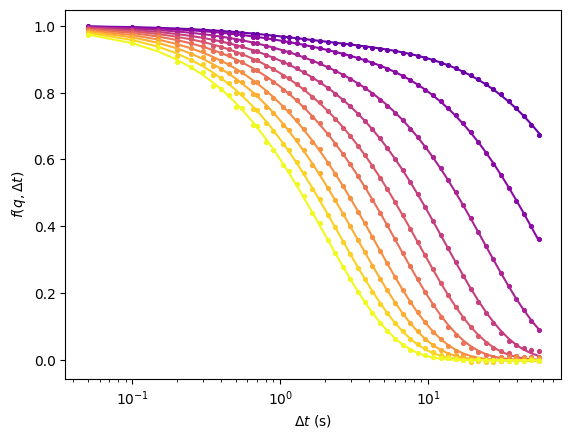

In [12]:
fig21 = plt.figure()
fig21.tight_layout()
fig21.set_figheight(fig21.get_figheight())
gs21 = fig21.add_gridspec(len(aa_res), hspace=0)
axs21 = gs21.subplots(sharex=True)

k_idx = []
cspace = []

for n, (k, K) in enumerate(zip(k_min, k_max)):
    idx_min = np.argwhere(aa_res[n].k >= k)[0,0]
    idx_max = np.argwhere(aa_res[n].k <= K)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)
    k_idx.append(k_list)
    cspace.append(color_space(len(k_idx[-1])))

for i, a in enumerate(aa_res):
    for n, k in enumerate(k_idx[i]):
        y = 1 - (a.data[k] - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        y_fit = 1 - (model_res[i][k].best_fit - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        axs21.plot(a.tau, y, '.', color=cspace[i][n])
        axs21.plot(a.tau, y_fit, '-', color=cspace[i][n])

axs21.set_xscale('log')
axs21.set_xlabel(r'$\Delta t$ (s)')
axs21.set_ylabel(r'$f(q, \Delta t)$')

fig21.savefig(f"g1_fit.pdf", dpi=600)